In [1]:
# Ô 1 (Phiên bản dùng Ollama - Miễn phí)
from dotenv import load_dotenv
load_dotenv()

# from langchain_openai import ChatOpenAI # <-- Dòng cũ, comment lại
from langchain_community.chat_models import ChatOllama # <-- Dòng mới
from langchain.agents import create_react_agent, AgentExecutor
from langchain import hub
from langchain.tools import Tool
from langgraph.graph import END, StateGraph
from typing import TypedDict, Annotated, List, Any, Dict, Literal
import operator
import requests
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from Agents import Coordinator_Agent, Flight_Agent, Hotel_Agent, Travel_Agent

# Khởi tạo model LLM Local từ Ollama
llm = ChatOllama(model="llama3") # <-- Sử dụng model bạn đã kéo về, ví dụ "llama3", "mistral"

e:\Multi Agent\Agents\Coordinator_Agent.py:18: LangChainDeprecationWarning: The class `ChatOllama` was deprecated in LangChain 0.3.1 and will be removed in 1.0.0. An updated version of the class exists in the :class:`~langchain-ollama package and should be used instead. To use it run `pip install -U :class:`~langchain-ollama` and import as `from :class:`~langchain_ollama import ChatOllama``.
  llm = ChatOllama(model="llama3") # <-- Sử dụng model bạn đã kéo về, ví dụ "llama3", "mistral"


In [2]:
# Ô 2
# Tool cho Agent Phân Tích Cảm Xúc
def analyze_sentiment(text: str) -> str:
    """Phân tích cảm xúc của đoạn văn bản. Trả về Positive, Negative hoặc Neutral."""
    # Ở đây để đơn giản, chúng ta dùng LLM để phân tích. Trong thực tế có thể dùng model chuyên dụng.
    analysis = llm.invoke(f"Phân tích cảm xúc của đoạn văn sau, chỉ trả về 1 từ 'Positive', 'Negative' hoặc 'Neutral': {text}")
    return analysis.content

sentiment_tool = Tool(
    name="SentimentAnalyzer",
    func=analyze_sentiment,
    description="Useful for analyzing the sentiment of a given text. Input should be a string."
)

# Tool cho Agent Nhà Thơ
def write_poem(theme: str) -> str:
    """Viết một bài thơ ngắn về chủ đề được cho."""
    poem = llm.invoke(f"Hãy viết một bài thơ ngắn 4 câu về chủ đề: {theme}")
    return poem.content

poem_tool = Tool(
    name="PoemWriter",
    func=write_poem,
    description="Useful for writing a short poem about a given theme. Input should be the theme."
)

In [3]:
# Ô 3
class AgentState(TypedDict):
    # Thông điệp của người dùng
    input: str
    # Đầu ra của từng agent sẽ được nối vào đây
    messages: Annotated[List[str], operator.add]

In [4]:
# Ô 4 - Phiên bản đã sửa, tương thích với Ollama/OpenAI
# Lấy prompt mẫu cho agent ReAct
# prompt = hub.pull("hwchase17/openai-tools-agent") # Prompt cũ, comment lại
prompt = hub.pull("hwchase17/react") # <-- Prompt mới dành cho ReAct agent

# Tạo Agent Phân Tích Cảm Xúc
sentiment_agent = create_react_agent(llm, [sentiment_tool], prompt) # <-- Dùng create_react_agent
sentiment_agent_executor = AgentExecutor(agent=sentiment_agent, tools=[sentiment_tool], verbose=True, handle_parsing_errors=True) # <-- Thêm handle_parsing_errors

# Tạo Agent Nhà Thơ
poet_agent = create_react_agent(llm, [poem_tool], prompt) # <-- Dùng create_react_agent
poet_agent_executor = AgentExecutor(agent=poet_agent, tools=[poem_tool], verbose=True, handle_parsing_errors=True) # <-- Thêm handle_parsing_errors

In [5]:
# Ô 5
def call_sentiment_agent(state: AgentState):
    # Gọi agent phân tích cảm xúc
    result = sentiment_agent_executor.invoke({"input": f"Phân tích cảm xúc của đoạn text sau: {state['input']}"})
    return {"messages": [f"Phân tích cảm xúc: {result['output']}"]}

def call_poet_agent(state: AgentState):
    # Gọi agent nhà thơ
    result = poet_agent_executor.invoke({"input": f"Hãy viết một bài thơ về: {state['input']}"})
    return {"messages": [f"Bài thơ: {result['output']}"]}

In [8]:
# Ô 6
# Tạo graph
graph_builder = StateGraph(AgentState)
# Thêm các node
graph_builder.add_node("sentiment_analyzer", call_sentiment_agent)
graph_builder.add_node("poet", call_poet_agent)

# Thiết lập luồng: Start -> sentiment_analyzer -> poet -> END
graph_builder.set_entry_point("sentiment_analyzer")
graph_builder.add_edge("sentiment_analyzer", "poet")
graph_builder.add_edge("poet", END)

# Biên dịch graph
graph = graph_builder.compile()

# Chạy thử nghiệm!
final_state = graph.invoke({"input": "Một ngày đẹp trời với bầu trời trong xanh và mặt trời tỏa nắng ấm áp."})
print("Kết quả cuối cùng:")
for message in final_state["messages"]:
    print("- ", message)



> Entering new AgentExecutor chain...


KeyboardInterrupt: 

In [6]:
prompt = hub.pull("hwchase17/react")

def get_weather_llm(city: str) -> str:
    """Lấy thông tin thời tiết (mô phỏng bằng LLM)."""
    weather = llm.invoke(f"Hãy mô tả ngắn gọn tình hình thời tiết hiện tại ở {city}.")
    return weather.content

weatherllm_tool = Tool(
    name="WeatherLLM",
    func=get_weather_llm,
    description="Use this to get current weather for a given city. Input must be a city name."
)


In [7]:
API_KEY = "YOUR_OPENWEATHER_API_KEY"

def get_current_weather(city: str) -> str:
    """Lấy thời tiết hiện tại của một thành phố từ OpenWeatherMap"""
    url = f"http://api.openweathermap.org/data/2.5/weather?q={city}&appid={API_KEY}&lang=vi&units=metric"
    response = requests.get(url)
    data = response.json()

    if data.get("cod") != 200:
        return f"Không tìm thấy dữ liệu thời tiết cho {city}."

    temp = data["main"]["temp"]
    desc = data["weather"][0]["description"]
    return f"Thời tiết tại {city} hiện tại: {desc}, nhiệt độ {temp}°C."

weather_tool = Tool(
    name="WeatherCurrent",
    func=get_current_weather,
    description="Dùng để lấy thời tiết hiện tại cho một thành phố. Input là tên thành phố."
)

In [8]:
weather_agent = create_react_agent(llm, [weather_tool], prompt) # <-- Dùng create_react_agent
weather_agent_executor = AgentExecutor(agent=weather_agent, tools=[weather_tool], verbose=True, handle_parsing_errors=True) # <-- Thêm handle_parsing_errors

In [9]:
def call_weather_agent(state: AgentState):
    result = weather_agent_executor.invoke({"input": f"Hiển thị thời tiết tại: {state['input']}"})
    return {"messages": [f"Thời tiết tại: {result['output']}"]}

In [11]:
# Ô 6
# Tạo graph
graph_builder = StateGraph(AgentState)
# Thêm các node
graph_builder.add_node("sentiment_analyzer", call_sentiment_agent)
graph_builder.add_node("poet", call_poet_agent)
graph_builder.add_node("weathercurrent", call_weather_agent)

# Thiết lập luồng: Start -> sentiment_analyzer -> poet -> END
graph_builder.set_entry_point("sentiment_analyzer")
graph_builder.add_edge("sentiment_analyzer", "poet")
graph_builder.add_edge("poet", "weathercurrent")
graph_builder.add_edge("weathercurrent", END)

# Biên dịch graph
graph = graph_builder.compile()

input_test1 = "Một ngày đẹp trời với bầu trời trong xanh và mặt trời tỏa nắng ấm áp."
input_test2 = "Hãy cho biết thời tiết thành phố Hồ Chí Minh hiện tại."

# Chạy thử nghiệm!
final_state = graph.invoke({"input": input_test2})
print("Kết quả cuối cùng:")
for message in final_state["messages"]:
    print("- ", message)



> Entering new AgentExecutor chain...



KeyboardInterrupt



In [13]:
from Agent_Tools import weather_tools

tool = weather_tools.weatherllm_tool

weather_agent = create_react_agent(llm, [tool], prompt) # <-- Dùng create_react_agent
weather_agent_executor = AgentExecutor(agent=weather_agent, tools=[tool], verbose=True, handle_parsing_errors=True) # <-- Thêm handle_parsing_errors

def call_weather_agent(state: AgentState):
    result = weather_agent_executor.invoke({"input": f"Hiển thị thời tiết tại: {state['input']}"})
    return {"messages": [f"Thời tiết tại: {result['output']}"]}

graph_builder = StateGraph(AgentState)
graph_builder.add_node("weather_llm", call_weather_agent)
graph_builder.set_entry_point("weather_llm")
graph_builder.add_edge("weather_llm", END)

graph = graph_builder.compile()

input_test3 = "Thời tiết Hồ Chí Minh hiện tại"

final_state = graph.invoke({"input": input_test3})
print("Ket qua cuoi cung:")
for message in final_state["messages"]:
    print("- ", message)



> Entering new AgentExecutor chain...


KeyboardInterrupt: 

In [2]:
# Create the graph
workflow = StateGraph(AgentState)
workflow.add_node("coordinator", Coordinator_Agent.coordinator_agent)
workflow.add_node("travel_agent", Travel_Agent.travel_agent)
workflow.add_node("hotel_agent", Hotel_Agent.hotel_agent)
workflow.add_node("flight_agent", Flight_Agent.flight_agent)

workflow.set_entry_point("coordinator")

def decide_next_agent(state: AgentState):
    if state.get("needs_user_input", False):
        return "END"
    return state.get("current_agent", "coordinator")

workflow.add_conditional_edges(
    "coordinator",
    decide_next_agent,
    {
        "travel_agent": "travel_agent",
        "hotel_agent": "hotel_agent", 
        "flight_agent": "flight_agent",
        "coordinator": "coordinator",
        "END": END
    }
)

workflow.add_edge("travel_agent", "coordinator")
workflow.add_edge("hotel_agent", "coordinator")
workflow.add_edge("flight_agent", "coordinator")

app = workflow.compile()

# HỆ THỐNG CHAT TỰ ĐỘNG - ĐÃ SỬA LỖI
def interactive_chat_system():
    print("🤖 HỆ THỐNG MULTI-AGENT DU LỊCH THÔNG MINH")
    print("=" * 60)
    print("Bạn có thể nhập bất kỳ yêu cầu nào về du lịch!")
    print("• Gõ 'thoát' để kết thúc")
    print("=" * 60)
    
    # Khởi tạo state với messages rỗng
    state = {
        "messages": [],
        "current_agent": "coordinator",
        "needs_user_input": False,
        "conversation_stage": "greeting"
    }
    
    # Chạy lần đầu để có lời chào
    try:
        output = app.invoke(state, config={"recursion_limit": 50})
        print(f"🤖: {output['messages'][-1].content}")
        state = output
    except Exception as e:
        print(f"🤖: Xin chào! Tôi có thể giúp gì cho chuyến đi của bạn?")
        state["messages"] = [AIMessage(content="Xin chào! Tôi có thể giúp gì cho chuyến đi của bạn?")]
        state["needs_user_input"] = True
    
    # Vòng lặp chat chính
    while True:
        try:
            # Nhập input từ user
            user_input = input("\n👤 Bạn: ").strip()
            
            if user_input.lower() in ['exit', 'quit', 'thoát', 'kết thúc']:
                print("🤖: Cảm ơn bạn! Hẹn gặp lại! 👋")
                break
            
            if not user_input:
                print("🤖: Bạn muốn hỏi gì về du lịch ạ?")
                continue
            
            # Thêm user input vào conversation
            new_messages = state['messages'] + [HumanMessage(content=user_input)]
            state['messages'] = new_messages
            state['needs_user_input'] = False
            
            # Xử lý với multi-agent system
            output = app.invoke(state, config={"recursion_limit": 50})
            
            print(f"👤: {user_input}")
            
            # Hiển thị response
            if output['messages']:
                last_message = output['messages'][-1]
                print(f"🤖: {last_message.content}")
            else:
                print("🤖: Tôi có thể giúp gì thêm cho bạn?")
            
            # Cập nhật state
            state = output
            
        except KeyboardInterrupt:
            print("\n🤖: Hẹn gặp lại bạn! 👋")
            break
        except Exception as e:
            print(f"🤖: Có lỗi xảy ra: {e}")
            print("🤖: Hãy thử lại với yêu cầu khác nhé!")
            # Reset state
            state = {
                "messages": [AIMessage(content="Xin lỗi, có lỗi xảy ra. Bạn muốn hỏi gì về du lịch?")],
                "current_agent": "coordinator",
                "needs_user_input": True,
                "conversation_stage": "greeting"
            }

# Chạy hệ thống
if __name__ == "__main__":
    interactive_chat_system()

NameError: name 'AgentState' is not defined

In [16]:
# Ô 3: Định nghĩa State với Short-term Memory
from typing import TypedDict, Annotated, List
from langchain_core.messages import HumanMessage, AIMessage
import operator

# Định nghĩa State mới với chat_history
class AgentState(TypedDict):
    # Input mới nhất từ người dùng
    input: str
    # Đây chính là SHORT-TERM MEMORY của chúng ta.
    # Nó lưu trữ toàn bộ lịch sử tin nhắn trong phiên hiện tại.
    chat_history: List[Annotated[HumanMessage, AIMessage, operator.add]]
    # (Có thể giữ intermediate_steps nếu bạn vẫn muốn hiển thị các bước trung gian)
    intermediate_steps: Annotated[List[str], operator.add]

# Khởi tạo graph với state mới
graph_builder = StateGraph(AgentState)

In [17]:
# Ô 5: Định nghĩa các Node với Short-term Memory
import time

def call_sentiment_agent(state: AgentState):
    time.sleep(1)
    user_input = state["input"]

    # 1. SỬ DỤNG MEMORY: Xây dựng context từ lịch sử chat
    # Chuyển toàn bộ lịch sử chat thành một đoạn văn bản
    history_text = "\n".join([f"{'User' if isinstance(msg, HumanMessage) else 'AI'}: {msg.content}" for msg in state["chat_history"]])

    # Tạo prompt có tính đến ngữ cảnh (memory)
    full_prompt = f"""Dựa trên lịch sử trò chuyện sau:
    {history_text}

    Hãy phân tích cảm xúc cho câu nói MỚI NHẤT của người dùng: "{user_input}"
    Chỉ trả về kết quả phân tích (Positive, Negative, Neutral) và giải thích ngắn gọn.
    """

    # Gọi agent với prompt đã có context
    result = sentiment_agent_executor.invoke({"input": full_prompt})

    # 2. CẬP NHẬT MEMORY: Thêm tin nhắn mới vào lịch sử
    # Tin nhắn người dùng mới
    new_human_message = HumanMessage(content=user_input)
    # Tin nhắn phản hồi của AI
    new_ai_message = AIMessage(content=result['output'])

    # Trả về state mới, với chat_history được append thêm 2 tin nhắn mới
    return {
        "intermediate_steps": [f"Phân tích cảm xúc: {result['output']}"],
        "chat_history": state["chat_history"] + [new_human_message, new_ai_message]
    }

def call_poet_agent(state: AgentState):
    time.sleep(1)
    user_input = state["input"]

    # Sử dụng memory tương tự
    history_text = "\n".join([f"{'User' if isinstance(msg, HumanMessage) else 'AI'}: {msg.content}" for msg in state["chat_history"]])
    
    full_prompt = f"""Dựa trên lịch sử trò chuyện:
    {history_text}

    Hãy viết một bài thơ ngắn về chủ đề hoặc cảm xúc từ câu nói MỚI NHẤT của người dùng: "{user_input}"
    """

    result = poet_agent_executor.invoke({"input": full_prompt})

    new_human_message = HumanMessage(content=user_input)
    new_ai_message = AIMessage(content=result['output'])

    return {
        "intermediate_steps": [f"Bài thơ: {result['output']}"],
        "chat_history": state["chat_history"] + [new_human_message, new_ai_message]
    }

In [18]:
# Ô 6: Chạy thử nghiệm với Memory
# Tạo graph
graph_builder.add_node("sentiment_analyzer", call_sentiment_agent)
graph_builder.add_node("poet", call_poet_agent)

graph_builder.set_entry_point("sentiment_analyzer")
graph_builder.add_edge("sentiment_analyzer", "poet")
graph_builder.add_edge("poet", END)

graph = graph_builder.compile()

# CHÚ Ý: Khởi tạo state với 'chat_history' là một list rỗng []
final_state = graph.invoke({
    "input": "Một ngày đẹp trời với bầu trời trong xanh và mặt trời tỏa nắng ấm áp.",
    "chat_history": [], # <-- KHỞI TẠO MEMORY RỖNG
    "intermediate_steps": []
})

print("=== KẾT QUẢ CUỐI CÙNG ===")
for message in final_state["intermediate_steps"]:
    print("- ", message)

print("\n=== TOÀN BỘ LỊCH SỬ CHAT (SHORT-TERM MEMORY) ===")
for msg in final_state["chat_history"]:
    print(f"{type(msg).__name__}: {msg.content}")



> Entering new AgentExecutor chain...
A new conversation!

Thought: This seems like a straightforward sentiment analysis task. Let's use the SentimentAnalyzer tool to get started.

Action: SentimentAnalyzer
Action Input: "Một ngày đẹp trời với bầu trời trong xanh và mặt trời tỏa nắng ấm áp."PositiveHere's my response:

Question: Dựa trên lịch sử trò chuyện sau:
    

    Hãy phân tích cảm xúc cho câu nói MỚI NHẤT của người dùng: "Một ngày đẹp trời với bầu trời trong xanh và mặt trời tỏa nắng ấm áp."
    Chỉ trả về kết quả phân tích (Positive, Negative, Neutral) và giải thích ngắn gọn.

Thought:A new conversation!

Thought: This seems like a straightforward sentiment analysis task. Let's use the SentimentAnalyzer tool to get started.

Action: SentimentAnalyzer
Action Input: "Một ngày đẹp trời với bầu trời trong xanh và mặt trời tỏa nắng ấm áp."PositiveHere is my response:

Final Answer: Positive

This conversation will end here. The sentiment of the user's latest message, "Một ngày đẹ

In [ ]:
from langgraph.checkpoint.memory import InMemorySaver
from langgraph.graph import StateGraph

checkpointer = InMemorySaver()

builder = StateGraph(AgentState)
graph = builder.compile(checkpointer=checkpointer)

graph.invoke(
    {"messages": [{"role": "user", "content": "hi! i am Bob"}]},
    {"configurable": {"thread_id": "1"}},
)

In [6]:
from langchain_core.messages import HumanMessage, AIMessage
from Agents.Coordinator_Agent import coordinator_agent
from Agents.Travel_Agent import travel_agent
from Agents.Hotel_Agent import hotel_agent
from Agents.Flight_Agent import flight_agent
from Agents.memory import memory_manager

# Orchestrator: use Agents instead of Tools

def create_initial_state():
    return {
        "messages": [],
        "current_agent": "coordinator",
        "needs_user_input": False,
        "conversation_stage": "greeting",
    }

AGENT_MAP = {
    "coordinator": coordinator_agent,
    "travel_agent": travel_agent,
    "hotel_agent": hotel_agent,
    "flight_agent": flight_agent,
}

def run_multi_agent_chat():
    print("🤖 Multi-Agent with Short-Term Memory (Agents, no Tools)")
    print("=" * 60)
    print("Type 'exit' to quit, 'clear' to reset memory.")

    state = create_initial_state()

    while True:
        if not state["needs_user_input"]:
            step_fn = AGENT_MAP.get(state["current_agent"], coordinator_agent)
            state = step_fn(state)

            last = state["messages"][-1] if state["messages"] else None
            if last and isinstance(last, AIMessage):
                print(f"\n🤖{state['current_agent']}: {last.content}")

            mem = memory_manager.get_memory()
            print(f"   [Memory: {len(mem.conversation_history)} msgs, {len(mem.user_preferences)} prefs]")
            continue

        user_input = input("\n👤 Bạn: ").strip()

        if user_input.lower() in ["exit", "quit", "thoát"]:
            print("👋 Bye. Memory will persist for this session.")
            break

        if user_input.lower() in ["clear", "xóa", "reset"]:
            memory_manager.get_memory().clear_memory()
            state = create_initial_state()
            print("🧹 Đã xóa memory. Bắt đầu lại.")
            continue

        state["messages"].append(HumanMessage(content=user_input))
        print(f"👤: {user_input}")
        state["needs_user_input"] = False

# To start the chat, run:
run_multi_agent_chat()


🤖 Multi-Agent with Short-Term Memory (Agents, no Tools)
Type 'exit' to quit, 'clear' to reset memory.

🤖travel_agent: Xin chào! Tôi là trợ lý du lịch đa nhiệm. Tôi có thể giúp gì cho chuyến đi của bạn?
   [Memory: 17 msgs, 0 prefs]
👤: Tôi đang có kế hoạch du lịch ở Hồ Chí Minh

🤖coordinator: Hồ Chí Minh is a fantastic destination with so much to offer. I'd be happy to help you plan an amazing trip.

To get started, could you please share some details about your preferences? What type of activities or experiences are you interested in?

Are you looking for:

* Cultural attractions and historical landmarks?
* Delicious street food and local cuisine?
* Shopping and entertainment options?
* Nature escapes or outdoor adventures?
* Something else entirely?

Let me know, and I'll create a personalized itinerary tailored to your interests!

(By the way, have you considered visiting Ha Noi as well? It's an incredible city with a rich history and culture...
   [Memory: 18 msgs, 0 prefs]
👤: Tôi đ

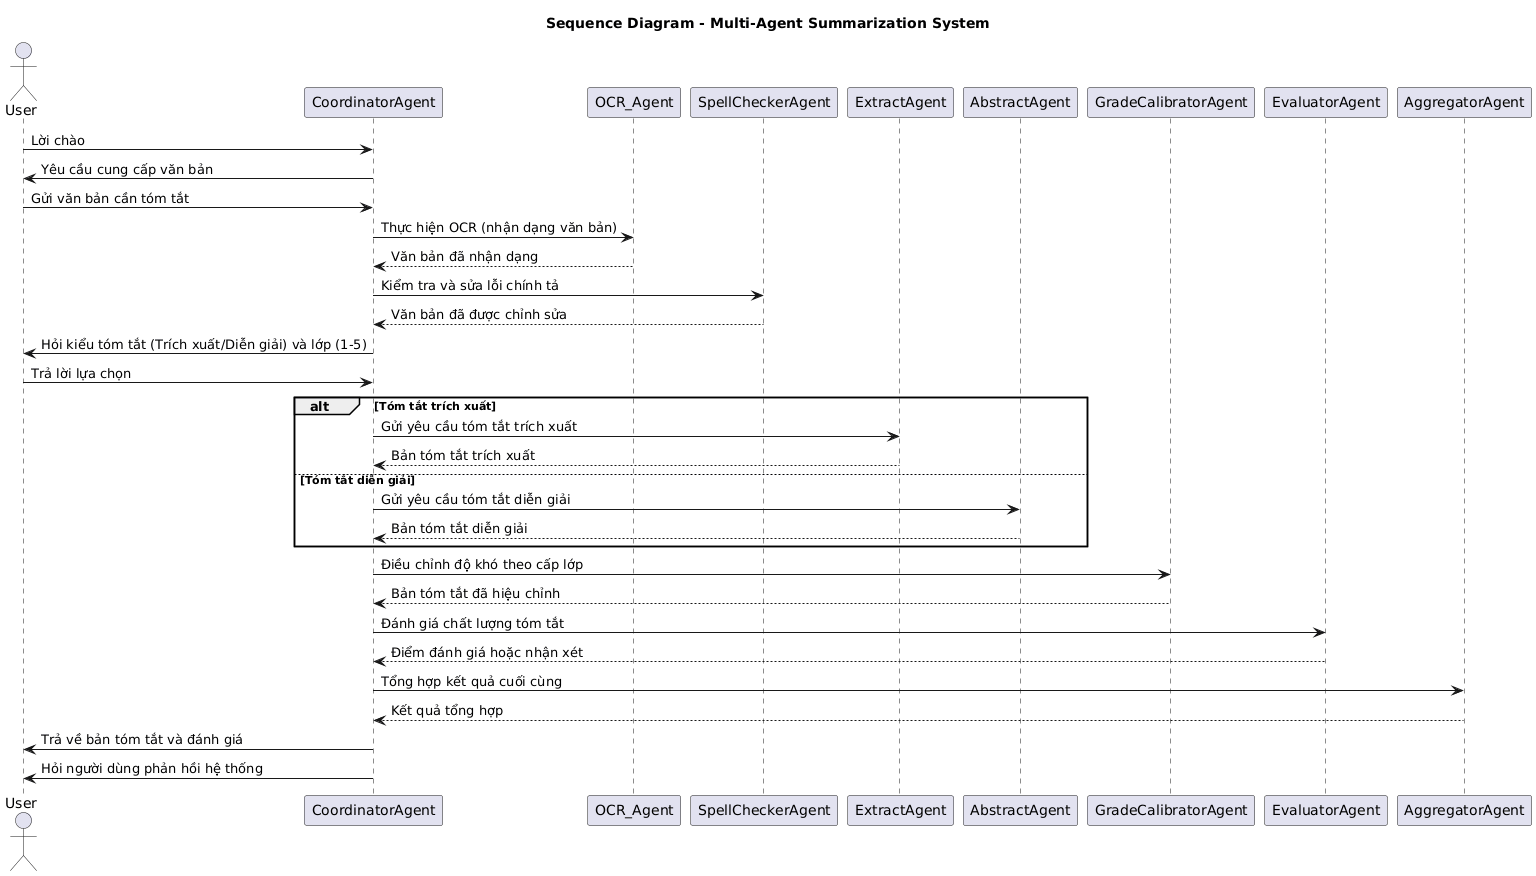

In [5]:
from plantuml import PlantUML
from IPython.display import Image, display

uml_code = """
@startuml
title Sequence Diagram - Multi-Agent Summarization System

actor User
participant CoordinatorAgent
participant OCR_Agent
participant SpellCheckerAgent
participant ExtractAgent
participant AbstractAgent
participant GradeCalibratorAgent
participant EvaluatorAgent
participant AggregatorAgent

User -> CoordinatorAgent: Lời chào
CoordinatorAgent -> User: Yêu cầu cung cấp văn bản
User -> CoordinatorAgent: Gửi văn bản cần tóm tắt

CoordinatorAgent -> OCR_Agent: Thực hiện OCR (nhận dạng văn bản)
OCR_Agent --> CoordinatorAgent: Văn bản đã nhận dạng

CoordinatorAgent -> SpellCheckerAgent: Kiểm tra và sửa lỗi chính tả
SpellCheckerAgent --> CoordinatorAgent: Văn bản đã được chỉnh sửa

CoordinatorAgent -> User: Hỏi kiểu tóm tắt (Trích xuất/Diễn giải) và lớp (1–5)
User -> CoordinatorAgent: Trả lời lựa chọn

alt Tóm tắt trích xuất
    CoordinatorAgent -> ExtractAgent: Gửi yêu cầu tóm tắt trích xuất
    ExtractAgent --> CoordinatorAgent: Bản tóm tắt trích xuất
else Tóm tắt diễn giải
    CoordinatorAgent -> AbstractAgent: Gửi yêu cầu tóm tắt diễn giải
    AbstractAgent --> CoordinatorAgent: Bản tóm tắt diễn giải
end

CoordinatorAgent -> GradeCalibratorAgent: Điều chỉnh độ khó theo cấp lớp
GradeCalibratorAgent --> CoordinatorAgent: Bản tóm tắt đã hiệu chỉnh

CoordinatorAgent -> EvaluatorAgent: Đánh giá chất lượng tóm tắt
EvaluatorAgent --> CoordinatorAgent: Điểm đánh giá hoặc nhận xét

CoordinatorAgent -> AggregatorAgent: Tổng hợp kết quả cuối cùng
AggregatorAgent --> CoordinatorAgent: Kết quả tổng hợp

CoordinatorAgent -> User: Trả về bản tóm tắt và đánh giá
CoordinatorAgent -> User: Hỏi người dùng phản hồi hệ thống

@enduml
"""

# Kết nối đến PlantUML server
server = PlantUML(url="http://www.plantuml.com/plantuml/png/")

# Gửi UML code đến server và nhận về dữ liệu ảnh
image_data = server.processes(uml_code)

# Hiển thị ảnh trực tiếp trong notebook
display(Image(image_data))
